### Project - Predict heart attack based on phisiological and physical parameters of the patient

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [1]:
# Get cleaned data from repository
!wget -N https://raw.githubusercontent.com/carcrupe/TFM/master/data/stroke_data_for_modeling.csv -P ../data

--2020-08-11 12:53:57--  https://raw.githubusercontent.com/carcrupe/TFM/master/data/stroke_data_for_modeling.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.132.133
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[151.101.132.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 1019525 (996K) [text/plain]
Guardando como: “../data/stroke_data_for_modeling.csv”

stroke_data_for_mod 100%[===================>] 995,63K  --.-KB/s    en 0,06s   

Falta la cabecera de fecha de la última modificación -- marcas de tiempo desactivadas.
2020-08-11 12:53:58 (15,3 MB/s) - “../data/stroke_data_for_modeling.csv” guardado [1019525/1019525]



In [2]:
# Get libraries and install them, just in case some of them are missing
!wget -N https://raw.githubusercontent.com/carcrupe/TFM/master/requirements/requirements_modeling.txt -P ../requirements

--2020-08-11 12:54:06--  https://raw.githubusercontent.com/carcrupe/TFM/master/requirements/requirements_modeling.txt
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.132.133
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[151.101.132.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 83 [text/plain]
Guardando como: “../requirements/requirements_modeling.txt”

requirements_modeli 100%[===================>]      83  --.-KB/s    en 0s      

Falta la cabecera de fecha de la última modificación -- marcas de tiempo desactivadas.
2020-08-11 12:54:06 (1,50 MB/s) - “../requirements/requirements_modeling.txt” guardado [83/83]



In [3]:
!pip install -r ../requirements/requirements_modeling.txt

     |████████████████████████████████| 6.8 MB 5.8 MB/s eta 0:00:01


  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

from scipy.stats import randint

from sklearn.metrics import classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV

%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
df_stroke = pd.read_csv('../data/stroke_data_for_modeling.csv', sep=';')
df_stroke.head() 

,Age,SystolicPressure,DiastolicPressure,Cholesterol,Target,Pulse
0,50,110,80,1,0,30
1,55,140,90,3,1,50
2,51,130,70,3,1,60
3,48,150,100,1,1,50
4,60,120,80,2,0,40


### Machine learning modeling - action plan

1. Train data for each model. This is a classification problem and we are interested in maximizing the recall, ideally, we want to diagnose as many patients as possible.

2. To measure and evaluate I will decide base on:
  1. Confusion matrix and classification report
  2. RandomizedSearchCV - tune hyperparameters to optimize recall
  3. Cross validation score
   
6. Set a data frame with all optimized models information 
7. Select the model with best performance and save it


In [11]:
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# Create target object and call it y
y = df_stroke['Target']
# Create X
X = df_stroke.loc[:, df_stroke.columns != 'Target']

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score','Model'])

**Decision Tree Classifier**

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate recall
val_predictions = tree_model.predict(test_X)
val_recall = recall_score(val_predictions, test_y)
print("Recall: {:,.3f}".format(val_recall))


Recall: 0.748


In [17]:
#We define a function that returns recall metric for a given max_leaf_node
def get_recall_tree(max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    rec = recall_score(test_y, preds_val)
    return(rec)

Text(0.5, 0, 'Max leaf nodes')

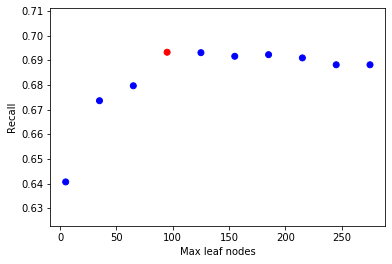

In [18]:
# Let us iterate to find the optimal tree parameters

candidate_max_leaf_nodes = np.arange(5, 300,30)
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
rec=[]
for x in candidate_max_leaf_nodes:
    rec.append(get_recall_tree(x,train_X, test_X, train_y, test_y))

# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[rec.index(max(rec))]

#Show the minimum accuracy highlighted in red
maxRec = np.max(rec)
mask = np.array(rec) == maxRec
color = np.where(mask, 'red', 'blue')
plt.scatter(candidate_max_leaf_nodes,rec, color=color);
plt.ylabel('Recall')
plt.xlabel('Max leaf nodes')


In [19]:
#Create tree model with the best max_leaf_nodes
improved_tree_model = DecisionTreeClassifier(max_leaf_nodes=best_tree_size, random_state=1)

# fit the data with the improved model and calculate recall
improved_tree_model.fit(train_X, train_y)
val_predictions = improved_tree_model.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f} - Best tree size: {:,.0f}".format(val_rec,best_tree_size))

Recall: 0.74748 - Best tree size: 95


In [20]:
# However, there are still some hyperparameters that can be tuned
# Let us use Randomized Grid search to optimize the model

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : np.arange(10,200,10),
              "max_depth": np.arange(1, 10),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1, scoring='recall')

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'max_leaf_nodes': 100, 'min_samples_leaf': 2}
Best score is 0.6742306235094714


In [21]:
#Fit tree model with the best hyperparameters
best_tree_model = tree_cv.best_estimator_.fit(train_X,train_y)

# Predict with the final model and calculate recall
val_predictions = best_tree_model.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f}".format(val_rec))

Recall: 0.74571


              precision    recall  f1-score   support

           0       0.69      0.76      0.72      5854
           1       0.75      0.68      0.71      6101

    accuracy                           0.72     11955
   macro avg       0.72      0.72      0.72     11955
weighted avg       0.72      0.72      0.72     11955



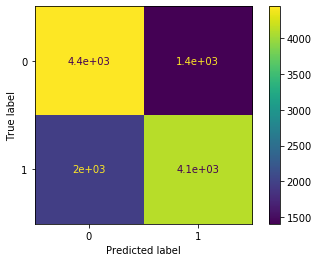

In [22]:
plot_confusion_matrix(best_tree_model, test_X, test_y)
print(classification_report(test_y,val_predictions))

In [23]:
#Also check the model with cross validation and store the mean of the recall validation as the score of the model
best_recall_cv=cross_val_score(best_tree_model, X, y, cv=10, scoring='recall').mean()
best_recall_cv

0.6746433082674843

In [24]:
model_score['DecisionTree'] =  [best_recall_cv, best_tree_model]

In [25]:
model_score

,DecisionTree
Model Score,0.674643
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


**Random Forest**

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the mean squared error of your Random Forest model on the validation data
predict_y=rf_model.predict(test_X)
rec_score = recall_score(test_y,predict_y)

print("Recall for Random Forest Model: {}".format(rec_score))


Recall for Random Forest Model: 0.6805441730863793


In [15]:
#We define a function that returns the Mean squared error of the Random Forest. We will check for this purpose
# two parameters of the Random Forest regressor, the depth and the leaf nodes
def get_recall_forest(max_depth, max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    rec = recall_score(test_y, preds_val)
    return(rec)

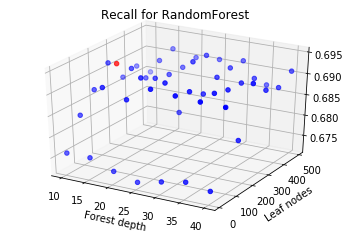

In [16]:
#Let us iterate to find the optimal forest parameters

step_leaf_nodes = 80
step_depth = 5
candidate_max_leaf_nodes = np.arange(10,(step_leaf_nodes*7)+10,step_leaf_nodes)
candidate_max_depth = np.arange(10,(step_depth*7)+10,step_depth)

# Write loop to find the ideal forest size from candidate_max_leaf_nodes and max_depth. 
# I did this before learning about hyperparameter tuning :)
rec=[]
depth_points=[]
leaf_points=[]
max_rec=0
for i, x_i  in enumerate(candidate_max_depth):
    for j, y_i  in enumerate(candidate_max_leaf_nodes):
        depth_points.append(candidate_max_depth[i])
        leaf_points.append(candidate_max_leaf_nodes[j])
        rec.append(get_recall_forest(x_i, y_i, train_X, test_X, train_y, test_y))
        if max(rec) > max_rec:
            max_rec = max(rec)
            # Store the best value of max_leaf_nodes and tree size
            best_depth = candidate_max_depth[i]
            best_forest_size = candidate_max_leaf_nodes[j]

#Show the maximum Recall highlighted in red and
# plot in 3D the recall corresponding to the leaf nodes and depths for the Random Forest
mask = np.array(rec) == max_rec
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(depth_points,leaf_points ,rec, color=color);
ax.set_title('Recall for RandomForest');
ax.set_xlabel('Forest depth');
ax.set_ylabel('Leaf nodes');

In [17]:
#Create improved random forest model
improved_forest_model = RandomForestClassifier(max_depth=best_depth, max_leaf_nodes=best_forest_size, random_state=0)

# fit the final model with the whole dataset and calculate error
improved_forest_model.fit(train_X, train_y)
val_predictions = improved_forest_model.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f} - Best depth: {:,.0f} - Best forest size: {:,.0f}".format(val_rec, best_depth,best_forest_size))

Recall: 0.75076 - Best depth: 15 - Best forest size: 170


In [18]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions 
param_dist = {"max_leaf_nodes" : np.arange(2,300,30),
              "max_depth": np.arange(3, 40,10),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Create the RandomizedSearchCV object, scoring the recall
forest_cv = RandomizedSearchCV(improved_forest_model, param_dist, cv=5, random_state=1, scoring='recall')

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Forest Parameters: {'criterion': 'gini', 'max_depth': 33, 'max_features': 5, 'max_leaf_nodes': 62, 'min_samples_leaf': 5}
Best score is 0.6889335489225795


In [19]:
#Fit forest model with the best hyperparameters
best_forest_model = forest_cv.best_estimator_.fit(train_X,train_y)

# Predict the test set with the final model and calculate recall
val_predictions = best_forest_model.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f}".format(val_rec))

Recall: 0.75013


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      5854
           1       0.75      0.69      0.72      6101

    accuracy                           0.72     11955
   macro avg       0.73      0.73      0.72     11955
weighted avg       0.73      0.72      0.72     11955



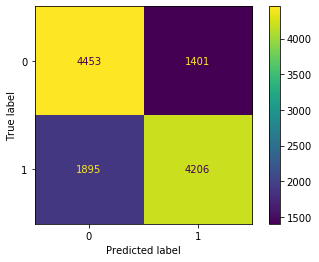

In [20]:
plot_confusion_matrix(best_forest_model, test_X, test_y)
print(classification_report(test_y,val_predictions))

In [33]:
#Finally check the recall of the model with cross validation
best_forest_recall_cv= cross_val_score(best_forest_model, X, y, cv=5, scoring='recall').mean()
best_forest_recall_cv

0.6844510155657649

In [34]:
#Save in a data frame the best achieved performance of the RandomForest model after cross validation
model_score['RandomForest'] =  [best_forest_recall_cv, best_forest_model]

In [35]:
model_score

,DecisionTree,RandomForest
Model Score,0.674643,0.684451
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


### Logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = log.predict(test_X)

val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f}".format(val_rec))

Recall: 0.74968


Text(0.5, 1.0, 'ROC Curve')

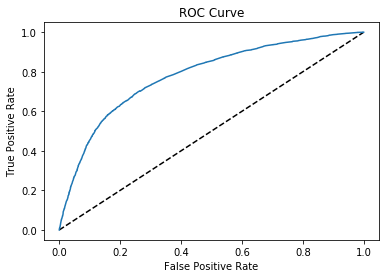

In [37]:
# For the logistic regression I also compute the ROC score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities
y_pred_prob = log.predict_proba(test_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [38]:
#We compute the area under the ROC
roc_auc_score(test_y, y_pred_prob)

0.781846098588575

In [39]:
# Since there ir only one hyperparameter to tune, let us check the best performance using a grid search
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log, param_grid, cv=5, scoring='recall')

# Fit it to the data
logreg_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 0.006105402296585327}
Best score is 0.6653346415896622


In [40]:
#Fit logistic regression model with the best hyperparameters
best_logistic_model = logreg_cv.best_estimator_.fit(train_X,train_y)

# fit the final model with the whole dataset and calculate error
val_predictions = best_logistic_model.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f}".format(val_rec))

Recall: 0.74963


              precision    recall  f1-score   support

           0       0.69      0.77      0.73      5854
           1       0.75      0.67      0.71      6101

    accuracy                           0.72     11955
   macro avg       0.72      0.72      0.72     11955
weighted avg       0.72      0.72      0.72     11955



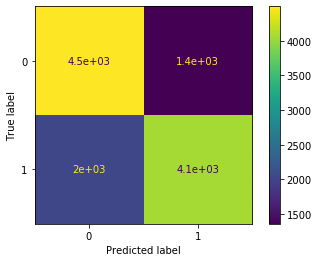

In [41]:
plot_confusion_matrix(best_logistic_model, test_X, test_y)
print(classification_report(test_y,val_predictions))

In [42]:
#Also check the model with cross validation for the best logistic model
best_log_recall = cross_val_score(best_logistic_model, X, y, cv=5, scoring='recall').mean()
best_log_recall

0.6668755090882718

In [43]:
model_score['LogisticRegression'] =  [best_log_recall, best_logistic_model]

In [44]:
 model_score

,DecisionTree,RandomForest,LogisticRegression
Model Score,0.674643,0.684451,0.666876
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","LogisticRegression(C=0.006105402296585327, cla..."


### K-Neighbors

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#For this model we are scaling, since for the neighbor model having comparable values should be more accurate

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set
knn_scaled = pipeline.fit(train_X,train_y)

# Predicting the Test set results
val_predictions = knn_scaled.predict(test_X)

# Measure recall of the model
val_rec = recall_score(val_predictions, test_y)
print("Validation recall: {:,.5f}".format(val_rec))

Validation recall: 0.66047


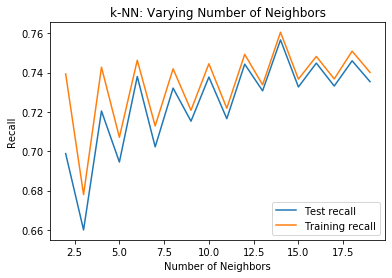

In [46]:
scaler = StandardScaler()

# Create X scaled
X_scaled = scaler.fit_transform(X)
train_X_scaled, test_X_scaled, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# Instead of using Randomized search or Grid seach, I am going to do the optimization manually.
# Let us iterate to find the best number of neighbors for the model and check performance for both training and test sets

neighbors = np.arange(2, 20)
train_recall = []
test_recall = []

# Loop over different values of k
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(train_X_scaled,train_y)    
    #Compute recall on the training set
    train_recall.append(recall_score(knn.predict(train_X_scaled), train_y))
    #Compute recall on the test set
    test_recall.append(recall_score(knn.predict(test_X_scaled), test_y))

# Generate plot
plt.title('k-NN: Varying Number of Neighbors');
plt.plot(neighbors, test_recall, label = 'Test recall');
plt.plot(neighbors, train_recall, label = 'Training recall');
plt.legend()
plt.xlabel('Number of Neighbors');
plt.ylabel('Recall');


We have an interesting result when optimizing the number of neighbors. It seems the recall is better for an even number of neighbors. This might happen just because the quality of the data and the features we have are not ideal.

In [47]:
#We take the best number of neighbors based on the previous graph. We select a trade off between training and test accuracy
best_neighbors = 6

#Create optimal random forest model
best_neighbor_model = KNeighborsClassifier(n_neighbors=best_neighbors)

# fit the final model with the train dataset and calculate recall
best_neighbor_model.fit(train_X_scaled, train_y)
val_predictions = best_neighbor_model.predict(test_X_scaled)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.5f} - Best number of neighbors: {:,.0f}".format(val_rec, best_neighbors))

Recall: 0.73803 - Best number of neighbors: 6


              precision    recall  f1-score   support

           0       0.66      0.77      0.71      5854
           1       0.74      0.62      0.68      6101

    accuracy                           0.70     11955
   macro avg       0.70      0.70      0.69     11955
weighted avg       0.70      0.70      0.69     11955



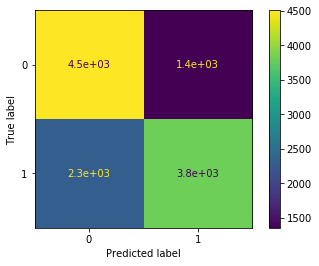

In [48]:
plot_confusion_matrix(best_neighbor_model, test_X_scaled, test_y)
print(classification_report(test_y,val_predictions))

In [49]:
#Also check the model with cross validation
best_recall_KNeighbors = cross_val_score(best_neighbor_model, X_scaled, y, cv=5, scoring='recall').mean()
best_recall_KNeighbors

0.6100657753692654

In [50]:
model_score['K-Neighbors'] =  [best_recall_KNeighbors,best_neighbor_model]

In [51]:
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors
Model Score,0.674643,0.684451,0.666876,0.610066
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","LogisticRegression(C=0.006105402296585327, cla...","KNeighborsClassifier(algorithm='auto', leaf_si..."


### Support Vector Machine (SVC)

In [52]:
# This model takes a really long time to run. I will not work on optimizing it since the recall does not improve much.

from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
svc.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = svc.predict(test_X)

val_rec= recall_score(val_predictions, test_y)
print("Recall: {:,.3f}".format(val_rec))

Recall: 0.767


In [53]:
#Also check the model with cross validation
best_recall_svm = cross_val_score(svc, X, y, cv=3, scoring='recall').mean()
best_recall_svm

0.6253372681687176

In [54]:
model_score['SVM'] =  [best_recall_svm,svc]
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors,SVM
Model Score,0.674643,0.684451,0.666876,0.610066,0.625337
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","LogisticRegression(C=0.006105402296585327, cla...","KNeighborsClassifier(algorithm='auto', leaf_si...","SVC(C=1.0, break_ties=False, cache_size=200, c..."


### Voting ensemble
We  combine the models to see if we can obtain a more accurate classifier

In [55]:
from sklearn.ensemble import VotingClassifier

# create the sub models, we select the three that perform better
estimators = []
estimators.append(('DecisionTree', best_tree_model))
estimators.append(('RandomForest', best_forest_model))
estimators.append(('LogisticRegression', best_logistic_model))

# create the ensemble model
ensemble = VotingClassifier(estimators)

# Cross validation with the ensembled model
recall_ensembled_scores = cross_val_score(ensemble, X,y, cv=5, scoring='recall').mean()

model_score['EnsembledModels'] =  [recall_ensembled_scores, ensemble]
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors,SVM,EnsembledModels
Model Score,0.674643,0.684451,0.666876,0.610066,0.625337,0.676618
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","LogisticRegression(C=0.006105402296585327, cla...","KNeighborsClassifier(algorithm='auto', leaf_si...","SVC(C=1.0, break_ties=False, cache_size=200, c...","VotingClassifier(estimators=[('DecisionTree',\..."


### XGBoost model

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbModel = XGBClassifier()
xgbModel.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
#We do a simple precition before tuning the model to see the recall
val_predictions = xgbModel.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.3f}".format(val_rec))

Recall: 0.747


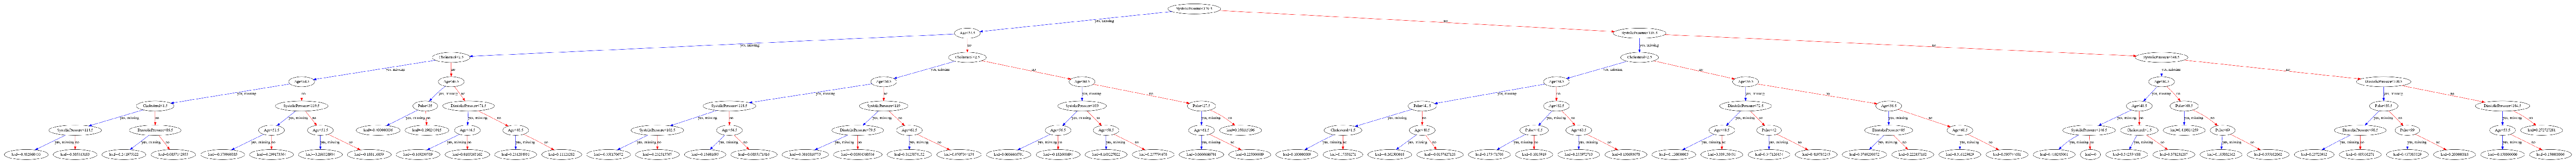

In [30]:
# Plot one of the decision trees as an example
tree = xgb.plot_tree(xgbModel, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(100, 30)

Test-accuracy-mean: 0.721


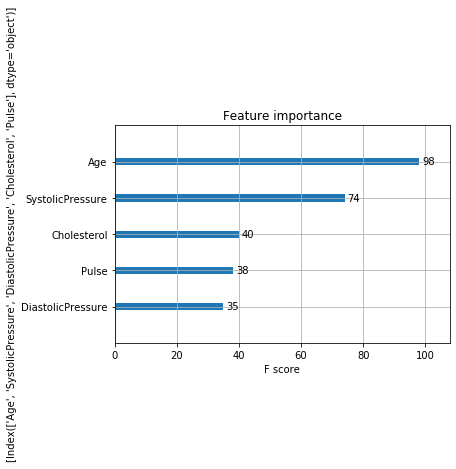

In [59]:
# Let us evaluate the importance of each feature in the model. 

stroke_train_DMatrix = xgb.DMatrix(data= train_X,label =train_y)
stroke_test_DMatrix = xgb.DMatrix(data= test_X,label =test_y)

# Create a parameter dictionary
params = {'objective':'binary:logistic', 'max_depth':4}


# Perform cross-validation
cv_results = xgb.cv(dtrain=stroke_train_DMatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error",  seed=1, as_pandas=True)

# Print the accuracy taking the value of the mean in the test error of the last cross valudation fold
print("Test-accuracy-mean: {:,.3f}".format(((1-cv_results["test-error-mean"]).iloc[-1])))

# Train the model 
xg_clf = xgb.train(dtrain=stroke_train_DMatrix, params=params, num_boost_round=20)

# Plot the feature importances
xgb.plot_importance(xg_clf, ylabel=[train_X.columns]);

It seems quite intuitive that features like age or systolic pressure are the main contributors for a heart stroke.

In [60]:
#We have explored the data and got the test prediction error. Let us now tune the model to improve the performance
#tuning the hyperparameters and optimize for recall

gbm_param_grid = {
    'n_estimators': np.arange(10,1000,200),
    'max_depth': range(2, 12),
    'learning_rate': np.arange(0.1,0.5,0.1)
}

# Perform random search of hyperparameteres
r_xgb = RandomizedSearchCV(estimator=xgbModel, param_distributions=gbm_param_grid, cv=3, 
                                    n_iter=5, verbose=1, random_state=42, scoring='recall', n_jobs=-1)

# Fit best_xgb to the data
r_xgb.fit(train_X,train_y)

# Print the best parameters and highest score
print("Best parameters found: ", r_xgb.best_params_)
print("Highest recall: ", r_xgb.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.0s finished


Best parameters found:  {'n_estimators': 610, 'max_depth': 3, 'learning_rate': 0.4}
Highest recall:  0.6889335075415864


In [61]:
# Using the optimized model I will measure recall
best_xgb = r_xgb.best_estimator_.fit(train_X,train_y)
val_predictions = best_xgb.predict(test_X)
val_rec = recall_score(val_predictions, test_y)
print("Recall: {:,.3f}".format(val_rec))

Recall: 0.749


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      5854
           1       0.75      0.69      0.72      6101

    accuracy                           0.72     11955
   macro avg       0.72      0.72      0.72     11955
weighted avg       0.73      0.72      0.72     11955



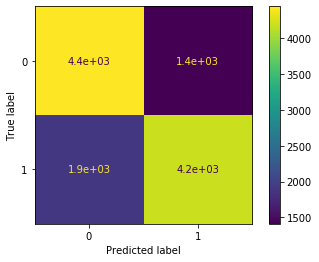

In [62]:
plot_confusion_matrix(best_xgb, test_X, test_y)
print(classification_report(test_y,val_predictions))

In [63]:
#Finally evaluate the model with cross validation
best_recall_xgb = cross_val_score(best_xgb, X, y, cv=3, scoring='recall').mean()
best_recall_xgb

0.6868868093745504

In [64]:
model_score['XGBBoost'] =  [best_recall_xgb, best_xgb]

## Save final model

In [65]:
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors,SVM,EnsembledModels,XGBBoost
Model Score,0.674643,0.684451,0.666876,0.610066,0.625337,0.676618,0.686887
Model,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","LogisticRegression(C=0.006105402296585327, cla...","KNeighborsClassifier(algorithm='auto', leaf_si...","SVC(C=1.0, break_ties=False, cache_size=200, c...","VotingClassifier(estimators=[('DecisionTree',\...","XGBClassifier(base_score=0.5, booster='gbtree'..."


In [66]:
final_scores = pd.DataFrame(model_score).transpose()

In [67]:
final_scores.sort_values(by='Model Score' ,ascending=False, inplace=True)
final_scores

,Model Score,Model
XGBBoost,0.686887,"XGBClassifier(base_score=0.5, booster='gbtree'..."
RandomForest,0.684451,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
EnsembledModels,0.676618,"VotingClassifier(estimators=[('DecisionTree',\..."
DecisionTree,0.674643,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
LogisticRegression,0.666876,"LogisticRegression(C=0.006105402296585327, cla..."
SVM,0.625337,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
K-Neighbors,0.610066,"KNeighborsClassifier(algorithm='auto', leaf_si..."


As we can see, we have very similar recall for the first two models. For simplicity I will select the Random Forest as the best model.

In [67]:
import pickle
best_model = final_scores['Model']['RandomForest']
pickle.dump(best_model,open("best.model","wb"))
